In [1]:
# 读取 QM9_demo 数据集
from utils.data import QM9DataExtractor

# 使用定义的QM9DataExtractor类用于加载提取数据
extractor = QM9DataExtractor('../data/demo/qm9_demo.csv')

# 读取所有 smiles_gdb 数据
smiles_list = extractor.get_smiles_list()
print(f"数据集中分子数量: {len(smiles_list)}")


数据集中分子数量: 2000


In [2]:
# 通过 smiles_list 获取所有分子的图结构
from utils.data import MoleculeToGraph
import torch
from tqdm import tqdm

# 初始化分子图转换器
mol_to_graph = MoleculeToGraph()

# 存储所有图数据
graph_data_list = []
properties_list = []
failed_molecules = []

print("开始转换分子为图结构...")

for i, smiles in enumerate(tqdm(smiles_list, desc="转换进度")):
    try:
        # 获取分子完整信息
        molecule_info = extractor.get_molecule_info(i)

        # 转换为图结构
        graph_data = mol_to_graph.convert_to_graph(
            molecule_info,
            smiles=smiles
        )

        # 添加属性信息
        graph_data['y'] = torch.tensor(
            molecule_info['properties_data']['property_vector'],
            dtype=torch.float
        )
        graph_data['smiles'] = smiles

        graph_data_list.append(graph_data)
        properties_list.append(molecule_info['properties_data']['properties'])

    except Exception as e:
        failed_molecules.append((i, smiles, str(e)))
        print(f"分子 {i} ({smiles}) 转换失败: {e}")

print(f"\n转换完成!")
print(f"成功转换: {len(graph_data_list)} 个分子")
print(f"转换失败: {len(failed_molecules)} 个分子")

if graph_data_list:
    print(f"\n图结构信息示例:")
    sample_graph = graph_data_list[0]
    print(f"节点数量: {sample_graph['num_nodes']}")
    print(f"边数量: {sample_graph['num_edges']}")
    print(f"节点特征维度: {sample_graph['x'].shape}")
    print(f"边特征维度: {sample_graph['edge_attr'].shape}")
    print(f"属性向量维度: {sample_graph['y'].shape}")


开始转换分子为图结构...


转换进度: 100%|██████████| 2000/2000 [00:04<00:00, 489.94it/s]


转换完成!
成功转换: 2000 个分子
转换失败: 0 个分子

图结构信息示例:
节点数量: 5
边数量: 8
节点特征维度: torch.Size([5, 17])
边特征维度: torch.Size([8, 7])
属性向量维度: torch.Size([15])



Graph data statistics:
Nodes - Min: 3, Max: 23, Mean: 13.8
Edges - Min: 4, Max: 44, Mean: 26.9


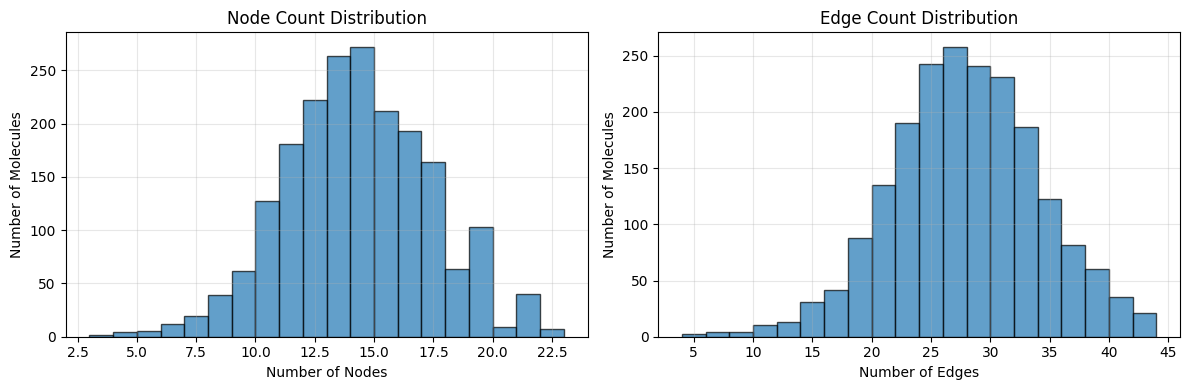

In [3]:
# 分析图数据统计信息
import numpy as np
import matplotlib.pyplot as plt

if graph_data_list:
    # 统计节点数分布
    node_counts = [graph['num_nodes'] for graph in graph_data_list]
    edge_counts = [graph['num_edges'] for graph in graph_data_list]

    print(f"\nGraph data statistics:")
    print(f"Nodes - Min: {min(node_counts)}, Max: {max(node_counts)}, Mean: {np.mean(node_counts):.1f}")
    print(f"Edges - Min: {min(edge_counts)}, Max: {max(edge_counts)}, Mean: {np.mean(edge_counts):.1f}")

    # 可视化分布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(node_counts, bins=20, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Number of Molecules')
    ax1.set_title('Node Count Distribution')
    ax1.grid(True, alpha=0.3)

    ax2.hist(edge_counts, bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Number of Edges')
    ax2.set_ylabel('Number of Molecules')
    ax2.set_title('Edge Count Distribution')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [4]:
# 保存图数据用于后续模型训练
import pickle

if graph_data_list:
    # 保存为pickle文件
    save_data = {
        'graphs': graph_data_list,
        'properties': properties_list,
        'failed_molecules': failed_molecules,
        'metadata': {
            'total_molecules': len(smiles_list),
            'successful_conversions': len(graph_data_list),
            'failed_conversions': len(failed_molecules),
            'property_names': extractor.property_columns
        }
    }

    save_path = '../data/processed/qm9_demo_graphs.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"图数据已保存到: {save_path}")
    print(f"数据包含: {len(graph_data_list)} 个图结构")
else:
    print("没有成功转换的图数据，跳过保存")


图数据已保存到: ../data/processed/qm9_demo_graphs.pkl
数据包含: 2000 个图结构


In [5]:
# 加载并验证保存的图数据
import pickle
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np

# Load saved graph data
save_path = '../data/processed/qm9_demo_graphs.pkl'
with open(save_path, 'rb') as f:
    loaded_data = pickle.load(f)

graphs = loaded_data['graphs']
properties = loaded_data['properties']
metadata = loaded_data['metadata']

print(f"Loaded {len(graphs)} molecular graphs")
print(f"Property names: {metadata['property_names']}")
print(f"Total molecules: {metadata['total_molecules']}")
print(f"Successful conversions: {metadata['successful_conversions']}")

# Verify first graph structure
if graphs:
    sample_graph = graphs[0]
    print(f"\nSample graph structure:")
    print(f"Node features shape: {sample_graph['x'].shape}")
    print(f"Edge index shape: {sample_graph['edge_index'].shape}")
    print(f"Edge features shape: {sample_graph['edge_attr'].shape}")
    print(f"Property vector shape: {sample_graph['y'].shape}")


Loaded 2000 molecular graphs
Property names: ['A', 'B', 'C', 'miu', 'alpha', 'homo', 'lumo', 'gap', 'R2', 'zpve', 'Uo', 'U', 'H', 'G', 'Cv']
Total molecules: 2000
Successful conversions: 2000

Sample graph structure:
Node features shape: torch.Size([5, 17])
Edge index shape: torch.Size([2, 8])
Edge features shape: torch.Size([8, 7])
Property vector shape: torch.Size([15])


In [6]:
# Prepare data for GNN training - target HOMO property
import torch.nn.functional as F

# Property index for HOMO (index 5 in property vector)
HOMO_INDEX = 5
property_names = ['A', 'B', 'C', 'miu', 'alpha', 'homo', 'lumo', 'gap', 'R2', 'zpve', 'Uo', 'U', 'H', 'G', 'Cv']
print(f"Target property: {property_names[HOMO_INDEX]} (HOMO)")

# Convert to PyG Data objects
pyg_data_list = []
homo_values = []

for graph_dict in graphs:
    # Extract HOMO value as target
    homo_value = graph_dict['y'][HOMO_INDEX].item()
    homo_values.append(homo_value)

    # Create PyG Data object
    data = Data(
        x=graph_dict['x'],
        edge_index=graph_dict['edge_index'],
        edge_attr=graph_dict['edge_attr'],
        y=torch.tensor([homo_value], dtype=torch.float32)
    )
    pyg_data_list.append(data)

print(f"Created {len(pyg_data_list)} PyG Data objects")
print(f"HOMO values range: {min(homo_values):.4f} to {max(homo_values):.4f}")

# Split data into train/validation/test
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test
train_data, temp_data = train_test_split(pyg_data_list, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Target property: homo (HOMO)
Created 2000 PyG Data objects
HOMO values range: -0.4286 to -0.1633
Train samples: 1400
Validation samples: 300
Test samples: 300


In [7]:
# Build simple GNN model using PyG
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=3):
        super(SimpleGNN, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Final prediction layer
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x, edge_index, batch):
        # Graph convolution layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Final prediction
        x = self.predictor(x)

        return x

# Initialize model
input_dim = pyg_data_list[0].x.shape[1]
model = SimpleGNN(input_dim=input_dim, hidden_dim=128, output_dim=1, num_layers=3)

print(f"Model input dimension: {input_dim}")
print(f"Model architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model input dimension: 17
Model architecture:
SimpleGNN(
  (convs): ModuleList(
    (0): GCNConv(17, 128)
    (1-2): 2 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Total parameters: 44,417
Trainable parameters: 44,417


In [8]:
# Training setup and loop
import torch.optim as optim
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

print(f"Training on device: {device}")
print(f"Batch size: {batch_size}")

# Training function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_samples = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out.squeeze(), batch.y.squeeze())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        num_samples += batch.num_graphs

    return total_loss / num_samples

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    num_samples = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out.squeeze(), batch.y.squeeze())

            total_loss += loss.item() * batch.num_graphs
            num_samples += batch.num_graphs

    return total_loss / num_samples

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../data/processed/best_gnn_model.pth')

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f}")

print(f"Training completed. Best validation loss: {best_val_loss:.6f}")


Training on device: cuda
Batch size: 32
Starting training...
Epoch  10/100 | Train Loss: 0.000850 | Val Loss: 0.000779
Epoch  20/100 | Train Loss: 0.000598 | Val Loss: 0.000412
Epoch  30/100 | Train Loss: 0.000439 | Val Loss: 0.000380
Epoch  40/100 | Train Loss: 0.000365 | Val Loss: 0.000319
Epoch  50/100 | Train Loss: 0.000322 | Val Loss: 0.000309
Epoch  60/100 | Train Loss: 0.000325 | Val Loss: 0.000424
Epoch  70/100 | Train Loss: 0.000298 | Val Loss: 0.000388
Epoch  80/100 | Train Loss: 0.000310 | Val Loss: 0.000254
Epoch  90/100 | Train Loss: 0.000353 | Val Loss: 0.000291
Epoch 100/100 | Train Loss: 0.000353 | Val Loss: 0.000290
Training completed. Best validation loss: 0.000238


Test Results:
Test MSE Loss: 0.000218
Test MAE: 0.010909
Test R² Score: 0.6782


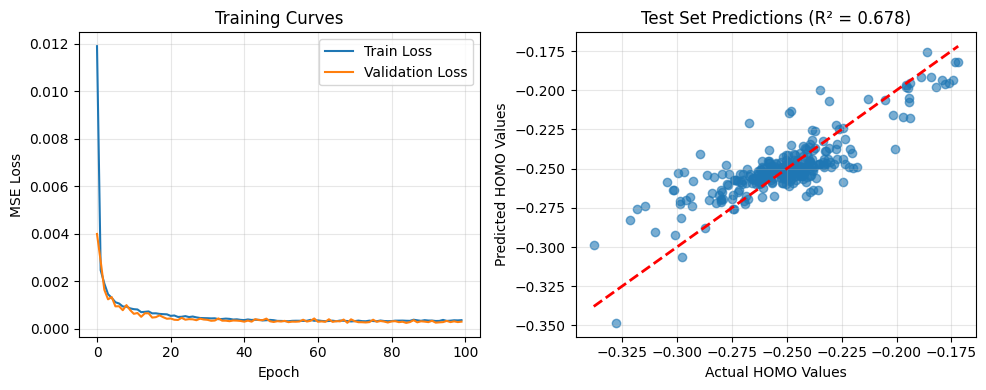

In [9]:
# Plot training curves and evaluate model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Load best model and evaluate
model.load_state_dict(torch.load('../data/processed/best_gnn_model.pth'))
test_loss = validate(model, test_loader, criterion, device)

# Get predictions for test set
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        test_predictions.extend(out.squeeze().cpu().numpy())
        test_targets.extend(batch.y.squeeze().cpu().numpy())

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

# Calculate metrics
mae = mean_absolute_error(test_targets, test_predictions)
r2 = r2_score(test_targets, test_predictions)

print(f"Test Results:")
print(f"Test MSE Loss: {test_loss:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(test_targets, test_predictions, alpha=0.6)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()], 'r--', lw=2)
plt.xlabel('Actual HOMO Values')
plt.ylabel('Predicted HOMO Values')
plt.title(f'Test Set Predictions (R² = {r2:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
